In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from tqdm import tqdm

### Discriminator

In [23]:
class Discriminator(nn.Module):
  def __init__(self, channels_img, features_d, num_classes, img_size):
    # features_d is the number of channels that we are gonna process
    super(Discriminator, self).__init__()

    self.img_size = img_size

    self.disc = nn.Sequential(
        # Input: N x channels_img x 64 x 64
        nn.Conv2d(
            channels_img+1, features_d, kernel_size=4, stride=2, padding=1
        ), # 32 x 32
        nn.LeakyReLU(0.2),
        self._block(features_d, features_d*2, 4, 2, 1), #16x16
        self._block(features_d*2, features_d*4, 4, 2, 1), # 8x8
        self._block(features_d*4, features_d*8, 4, 2, 1), # 4x4
        nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), # 1x1
    )

    self.embed = nn.Embedding(num_classes, img_size*img_size)


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.InstanceNorm2d(out_channels, affine=True), # LayerNorm <-> InstanceNorm
        nn.LeakyReLU(0.2),
    )

  def forward(self, x, labels):
    embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
    x = torch.cat([x, embedding], dim=1) # N x C x img_size(H) x img_size(W)
    return self.disc(x)

### Generator

In [24]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g, num_classes, img_size, embed_size):
        # features_d is the number of channels that we are gonna process
        # z_dim is the dimension of the noise vector
        super(Generator, self).__init__()

        self.img_size = img_size

        self.gen = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            self._block(z_dim + embed_size, features_g*16, 4, 1, 0), # N x features_g*16 x 4 x 4
            self._block(features_g*16, features_g*8, 4, 2, 1), # N x features_g*8 x 8 x 8
            self._block(features_g*8, features_g*4, 4, 2, 1), # N x features_g*4 x 16 x 16
            self._block(features_g*4, features_g*2, 4, 2, 1), # N x features_g*2 x 32 x 32
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(), # [-1, 1]
        )

        self.embed = nn.Embedding(num_classes, embed_size)

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(2) # latent vector: N x noise_dim x 1 x 1
        x = torch.cat([x, embedding], dim=1)
        return self.gen(x)


    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )


### Initialize Weights

In [25]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)


### Gradient Penalty

In [26]:
def gradient_penalty(critic, labels, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, labels)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

    return gradient_penalty

### Hyper Parameters

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMG_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_CLASSES = 10
GEN_EMBEDDING = 100
NUM_EPOCHS = 10
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

transforms = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
# comment mnist above and uncomment below for training on CelebA
# dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, GEN_EMBEDDING).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC, NUM_CLASSES, IMG_SIZE).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(2, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
  )
  (embed): Embedding(10, 4096

### Training

In [31]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(200, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(32, 1, kernel_si

In [28]:
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, labels) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        labels = labels.to(device)

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise, labels)
            critic_real = critic(real, labels).reshape(-1)
            critic_fake = critic(fake, labels).reshape(-1)
            gp = gradient_penalty(critic, labels, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake, labels).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

Epoch [0/10] Batch 100/938                   Loss D: -103.1738, loss G: 66.9841
Epoch [0/10] Batch 200/938                   Loss D: -113.2616, loss G: 94.6242
Epoch [0/10] Batch 300/938                   Loss D: -104.5218, loss G: 98.9781
Epoch [0/10] Batch 400/938                   Loss D: -94.2007, loss G: 91.6787
Epoch [0/10] Batch 500/938                   Loss D: -81.4907, loss G: 94.8849
Epoch [0/10] Batch 600/938                   Loss D: -68.6553, loss G: 90.7478
Epoch [0/10] Batch 700/938                   Loss D: -58.1140, loss G: 93.3699
Epoch [0/10] Batch 800/938                   Loss D: -45.6993, loss G: 95.0778
Epoch [0/10] Batch 900/938                   Loss D: -37.0454, loss G: 86.1600
Epoch [1/10] Batch 100/938                   Loss D: -25.1405, loss G: 90.5446
Epoch [1/10] Batch 200/938                   Loss D: -19.8849, loss G: 87.0989
Epoch [1/10] Batch 300/938                   Loss D: -14.9720, loss G: 90.8686
Epoch [1/10] Batch 400/938                   Loss

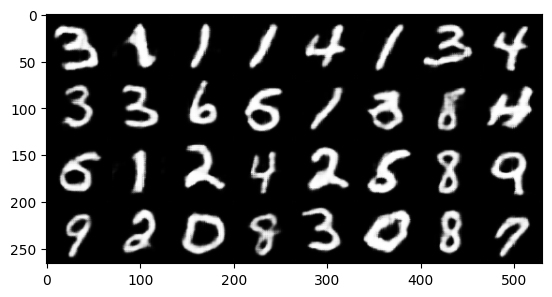

In [43]:
NUM_IMAGES = 32  # Number of images to generate

# Generate random noise and pass it through the generator
def generate_images(generator, num_images, z_dim, num_classes):
    noise = torch.randn(num_images, z_dim, 1, 1).to(device)  # Generate random noise
    labels = torch.randint(0, NUM_CLASSES, (num_images,)).to(device)  # Generate random labels using NUM_CLASSES
    fake_images = generator(noise, labels)  # Pass noise through the generator
    fake_images = fake_images * 0.5 + 0.5  # Rescale images to [0, 1] from [-1, 1]
    return fake_images


# Display the generated images
def show_images(images, num_images):
    grid = vutils.make_grid(images[:num_images], normalize=True, padding=2)
    plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy())  # Convert to NumPy for plotting
    plt.show()

# Set the generator to evaluation mode
gen.eval()

# Generate and display images
generated_images = generate_images(gen, NUM_IMAGES, Z_DIM, NUM_CLASSES) # Pass NUM_CLASSES to generate_images
show_images(generated_images, NUM_IMAGES)

In [35]:
torch.tensor(3)

tensor(3)